# Showing some of the dstoolbox features

The purpose of this notebook is to demonstrate some of the features of `dstoolbox` using a toy dataset that contains different categories of features.

## Imports

In [1]:
from functools import partial
import operator
import random

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

## Generate a toy dataset

Here we create a fictitious dataset of pupils with the goal of predicting their grades based on their name, age, city of birth, and body height. The dataset contains a mixture of numerical and non-numerical features. Although holding such a dataset is not a problem for a `pandas` `DataFrame`s, it is difficult to integrate it seamlessly with `scikit-learn`.

In [3]:
np.random.seed(1)

In [4]:
NAMES = ['Alice', 'Bob', 'Charlie', 'Dora', 'Eve', 'Fenchurch', 'Guido']

In [5]:
CITIES = ['London', 'Paris', 'New York', 'Berlin', 'Warsaw', 'Vancouver', 'Amsterdam', 'Rome']

In [6]:
AGES = [6, 7, 8, 9, 10, np.nan]

In [7]:
def _yield_names(n):
    for _ in range(n):
        yield random.choice(NAMES)

In [8]:
def _yield_age(n):
    for _ in range(n):
        yield random.choice(AGES)

In [9]:
def _yield_city(n):
    for _ in range(n):
        yield random.choice(CITIES)

In [10]:
def _yield_height(n):
    for _ in range(n):
        yield 140 + 20 * random.random()

In [11]:
def make_data(n):
    df = pd.DataFrame({
        'name': list(_yield_names(n)),
        'age': list(_yield_age(n)),
        'city': list(_yield_city(n)),
        'height': list(_yield_height(n)),
    })
    target = np.array([random.randint(0, 100) for _ in range(n)])
    return df, target

In [12]:
df, y = make_data(100)


In [13]:
df.head()

,age,city,height,name
0,10.0,London,150.305894,Dora
1,10.0,New York,144.471890,Alice
2,8.0,Paris,144.217773,Fenchurch
3,NaN,Paris,144.262594,Eve
4,10.0,Rome,150.056528,Charlie


In [14]:
df.shape

(100, 4)

In [15]:
y[:10]

array([85, 41, 27, 94, 76, 37, 69, 32, 60, 20])

## Working with `dstoolbox`

This part shows how we can get this dataset to work with `scikit-learn` thanks to `dstoolbox` features.

### Imports

In [16]:
from dstoolbox.pipeline import TimedPipeline
from dstoolbox.pipeline import DataFrameFeatureUnion
from dstoolbox.pipeline import DictFeatureUnion
from dstoolbox.transformers import ItemSelector
from dstoolbox.transformers import ParallelFunctionTransformer
from dstoolbox.transformers import ToDataFrame
from dstoolbox.transformers import XLabelEncoder

### Custom functions

In [17]:
def word_count_e(words):
    return np.expand_dims(np.array([word.count('e') for word in words]), axis=1)

In [18]:
def word_len(words):
    return np.expand_dims(np.array([len(word) for word in words]), axis=1)

### Define the feature transformation step

Here we will define a special FeatureUnion that takes `pandas` DataFrames as input and returns `pandas` DataFrames as output. Within this _DataFrameFeatureUnion_, we will make use of several other `dstoolbox` features that will facilitate the integration of `DataFrame`s with `scikit-learn`.

In [19]:
# Use dstoolbox's DataFrameFeatureUnion, which will return a DataFrame if all intermediate
# transformation steps return either a pandas DataFrame or a pandas Series.
feature_union = DataFrameFeatureUnion([
    # Now we define our feature set.

    # A boolean feature, namely, whether age is below 9 years.
    ('age_less_than_9', Pipeline([
        # ItemSelector allows us to select a specific column from the DataFrame.
        # The result would 1d but sklearn transformers usually expects features to be 2d.
        # Therefore, we set the force_2d argument to True.
        ('select_age', ItemSelector('age', force_2d=True)),
        # Let's impute the NaN values.
        ('impute_nan', Imputer(strategy='most_frequent')),
        # This FunctionTransformer will return True if age is less than 9.
        ('less_than_9', FunctionTransformer(partial(operator.lt, 9))),
        # Finally, transform the data to a DataFrame with the name 'age_less_than_9'.
        ('to_df', ToDataFrame(columns=['age_less_than_9'])),
    ])),
        
    # We also have city names; we want to encode those, treating them as categorical.
    ('city_label_encoded', Pipeline([
        # We use ItemSelector again to access the city values. As it returns a Series,
        # but we want a 2d array, we set force_2d to True.
        ('select_city', ItemSelector('city', force_2d=True)),
        # dstoolbox's XLabelEncoder is similar to sklearn's LabelEncoder but works on feature data.
        ('encode', XLabelEncoder()),
        # Again, let's transform the resuling ndarray to a pandas DataFrame.
        ('to_df', ToDataFrame(columns=['city_label_encoded'])),
    ])),
        
    # The height feature is fine, let's just take it as it is.
    # Since the returned value is already a Series object, no need to transform it further.
    ('raw_height', ItemSelector('height')),
        
    # Finally, we would like to derive 2 features based on the children's names.
    # First is the length of the name, second the number of the letter 'e' in the name.
    ('name_features', Pipeline([
        ('select_name', ItemSelector('name')),
        ('name_features', DictFeatureUnion([
            # Since determining the length and number of e's is an embarassingly parallel
            # task, we use dstoolbox's ParallelFunctionTransformer instead of sklearn's
            # FunctionTransformer.
            # Notice that we did not use lambdas here, since those cannot be pickled.
            ('name_length', ParallelFunctionTransformer(word_len, validate=False, n_jobs=2)),
            ('name_count_of_e', ParallelFunctionTransformer(word_count_e, validate=False, n_jobs=2)),
        ])),
        # Again, transform the output into a DataFrame, this time with 2 columns.
        # Since the incoming data from `DictFeatureUnion` is a dict, the column names
        # will be inferred automatically from the dict's keys, i.e.
        # `name_length` and `name_count_of_e`.
        ('to_df', ToDataFrame()),
    ])),
])

### Look at the result

We promised that we would get back a `pandas` `DataFrame`, here it is:

In [20]:
df_transformed = feature_union.fit_transform(df)

In [21]:
df_transformed.head()

,age_less_than_9,city_label_encoded,height,name_count_of_e,name_length
0,True,3,150.305894,0,4
1,True,4,144.471890,1,5
2,False,5,144.217773,1,9
3,False,5,144.262594,1,3
4,True,6,150.056528,1,7


As we can see, the column names are exactly as we expected.

### Full regression pipeline

We want to use those features to train an sklearn RandomForestRegressor. For good measure, we also add polynomial features to the mix and put all the ingredients into a Pipeline:

In [22]:
pipeline = TimedPipeline([
    ('features', feature_union),
    ('polynomial', PolynomialFeatures()),
    ('random_forest', RandomForestRegressor(n_estimators=100)),
])

As you probably noticed, we did not use a simple `sklearn` Pipeline. Instead, we use a `dstoolbox` TimedPipeline. This special pipeline works just as an `sklearn` Pipeline, except that it prints additional information about the time it took to step through the pipeline steps, and what shape the outcoming data has.

In [23]:
pipeline.fit(df, y)

{"name": "features"                    , "method": "fit_transform"     , "duration":        0.298, "shape": "100x5"}
{"name": "polynomial"                  , "method": "fit"               , "duration":        0.000, "shape": "-"}
{"name": "polynomial"                  , "method": "transform"         , "duration":        0.000, "shape": "100x21"}
{"name": "polynomial"                  , "method": "fit_transform"     , "duration":        0.001, "shape": "100x21"}
{"name": "random_forest"               , "method": "fit"               , "duration":        0.096, "shape": "-"}


TimedPipeline(sink=<built-in function print>,
       steps=[('features', DataFrameFeatureUnion(copy=True, ignore_index=True, keep_original=False,
           n_jobs=1,
           transformer_list=[('age_less_than_9', Pipeline(steps=[('select_age', ItemSelector(force_2d=True, key='age')), ('impute_nan', Imputer(axis=0, copy=True, missing_values='NaN', s...imators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

We immediately see that the generation of the features is the slowest step, followed by the model fit. Additionally, we see that we that the feature generation step produces 5 features, followed by 21 features after applying the polynomial fatures.

This kind of information would be tricky to get with `sklearn` features alone.

By the way, the printed outputs can be `eval`ed as dicts or parsed as `json`'s, which is useful for logging.

In [24]:
y_pred = pipeline.predict(df)

{"name": "features"                    , "method": "transform"         , "duration":        0.291, "shape": "100x5"}
{"name": "polynomial"                  , "method": "transform"         , "duration":        0.001, "shape": "100x21"}
{"name": "random_forest"               , "method": "predict"           , "duration":        0.005, "shape": "100"}


In [25]:
mean_squared_error(y, y_pred)

141.03073000000001

We can now generate a test dataset to validate our model. As the targets are completely random, we will find that our model totally overfits:

In [26]:
df_test, y_test = make_data(100)

In [27]:
y_pred = pipeline.predict(df_test)

{"name": "features"                    , "method": "transform"         , "duration":        0.284, "shape": "100x5"}
{"name": "polynomial"                  , "method": "transform"         , "duration":        0.001, "shape": "100x21"}
{"name": "random_forest"               , "method": "predict"           , "duration":        0.005, "shape": "100"}


In [28]:
mean_squared_error(y_test, y_pred)

1177.1097570000002

### Conclusion

The features from `dstoolbox` allowed us to integrate all processing steps into an `sklearn` `Pipeline`. Without them, we would probably have had to do a separate processing step that ingests the `DataFrame`'s different columns and returns a `numpy array`, which we would pass to the proper `sklearn` `Pipeline` in a second step.

The advantage of having all steps in one pipeline is that it is easier to handle and provides us with all the niceties that come with `sklearn` `Pipeline`'s, e.g. being able to pass them to ensemble models (e.g. `BaggingRegressor`), grid search over all parameters, changing any parameter with `set_params`, saving the whole pipeline in one file with `pickle`, etc.

## _Bonus_: Visualizing pipelines

A final goody we want to demonstrate is a tool to visualize `Pipeline`s and `FeatureUnion`s with the help of `dstoolbox`.

In [29]:
from IPython.display import Image
from dstoolbox.visualization import make_graph

For this, we first transform the pipeline to a `pydotplus` graph, then visualize that graph. Btw., this also works with normal `sklearn` `Pipeline`s and `FeatureUnion`s.

Note that this requires additional packages to be installed, namely `pydotplus` and `graphviz`. Those can be installed via `pip`.

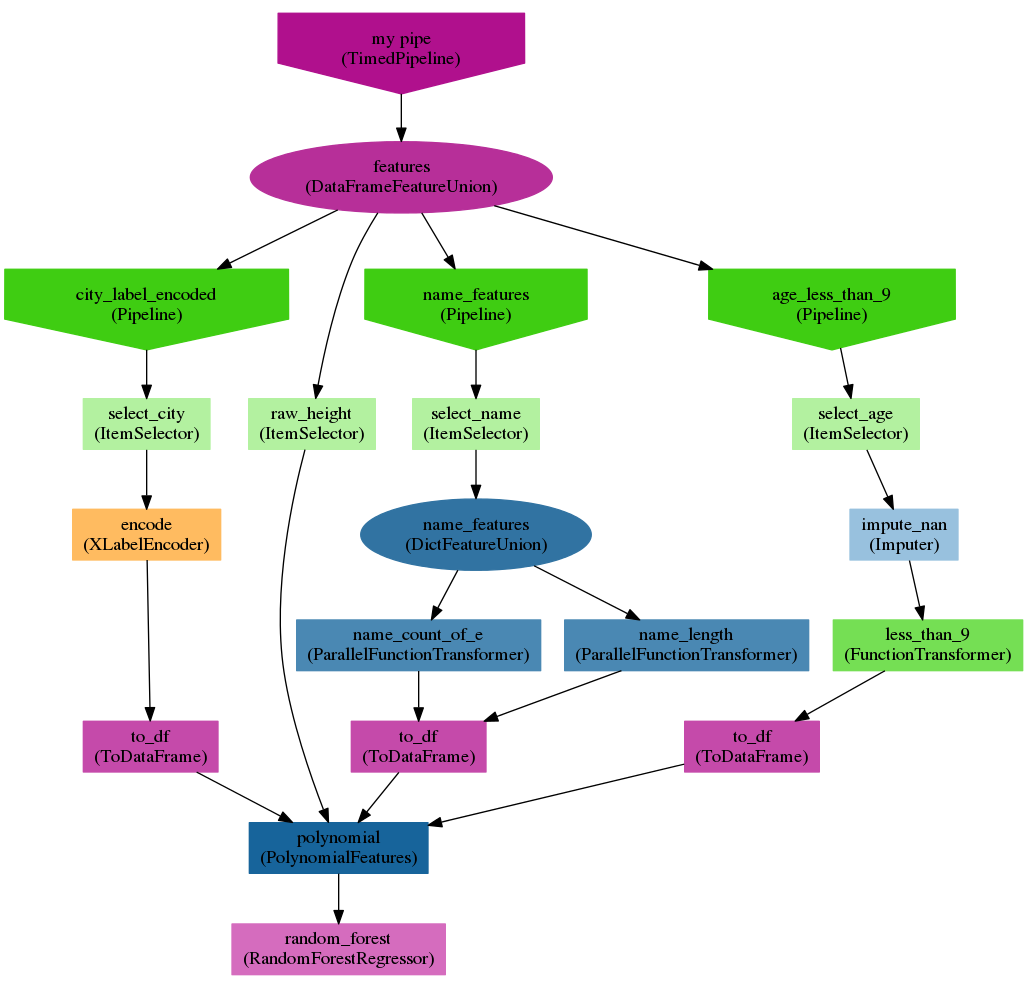

In [30]:
graph = make_graph('my pipe', pipeline)
Image(graph.create_png())